In [1]:
from glob import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from seasalt.salt_net import (
    SaltNetOneStageHandler,
    noise_adder_numpy,
    NoiseType,
    plot_before_after_and_original,
)
import torch
from math import floor

path_to_images = Path().resolve().joinpath("BSDS300-test")
image_paths = glob(f"{str(path_to_images)}/*.jpg")

im = Image.open(image_paths[96])

In [2]:
im_gs = im.convert("L")
arr = np.array(im_gs)
noise_parameter = 70/255
arr_sap = noise_adder_numpy(arr, noise_parameter, NoiseType.SAP)
arr_bernoulli = noise_adder_numpy(arr, noise_parameter, NoiseType.BERNOULLI)
arr_poisson = noise_adder_numpy(arr, noise_parameter, NoiseType.POISSON)
arr_gaussian = noise_adder_numpy(arr, noise_parameter, NoiseType.GUASSIAN)

In [3]:
from runpy import run_path
import os

from torch import Tensor

parameters = {
    "inp_channels": 1,
    "out_channels": 1,
    "dim": 48,
    "num_blocks": [4, 6, 6, 8],
    "num_refinement_blocks": 4,
    "heads": [1, 2, 4, 8],
    "ffn_expansion_factor": 2.66,
    "bias": False,
    "LayerNorm_type": "BiasFree",
    "dual_pixel_task": False,
}

load_arch = run_path(os.path.join("/Users/mostafakm/Documents/school/Restormer", "basicsr", "models", "archs", "restormer_arch.py"))
model = load_arch["Restormer"](**parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


checkpoint = torch.load("./models/restormer_gaussian_gray_denoising_blind.pth")
model.load_state_dict(checkpoint["params"])
model.eval().to("mps")


def np_to_torch_even_shape(arr) -> Tensor:
    x = torch.tensor(arr).unsqueeze(0).float()
    return x[:, :, : floor(x.shape[2] / 2) * 2, : floor(x.shape[3] / 2) * 2]

def predict_restormer(arr):
    tensor = np_to_torch_even_shape(arr)
    tensor=tensor.to("mps")
    tensor = model.forward(tensor)
    return tensor.squeeze().cpu().detach().numpy()

In [5]:
sum(p.numel() for p in model.parameters())

26109076

In [13]:
from torchinfo import summary

model.to("cpu")
summary(model, (1,1,256,256))

Layer (type:depth-idx)                             Output Shape              Param #
Restormer                                          [1, 1, 256, 256]          --
├─OverlapPatchEmbed: 1-1                           [1, 48, 256, 256]         --
│    └─Conv2d: 2-1                                 [1, 48, 256, 256]         432
├─Sequential: 1-2                                  [1, 48, 256, 256]         --
│    └─TransformerBlock: 2-2                       [1, 48, 256, 256]         --
│    │    └─LayerNorm: 3-1                         [1, 48, 256, 256]         48
│    │    └─Attention: 3-2                         [1, 48, 256, 256]         10,513
│    │    └─LayerNorm: 3-3                         [1, 48, 256, 256]         48
│    │    └─FeedForward: 3-4                       [1, 48, 256, 256]         20,574
│    └─TransformerBlock: 2-3                       [1, 48, 256, 256]         --
│    │    └─LayerNorm: 3-5                         [1, 48, 256, 256]         48
│    │    └─Attention: 3-6

In [4]:
# model = SaltNetOneStageHandler(denoiser_path="./models/pytorch_dfwb_data_13.h5")
# model = SaltNetOneStageHandler(denoiser_path="./models/pytorch_dfwb_data_128_6.h5")
# model = SaltNetOneStageHandler(
# denoiser_path="./models/pytorch_with_transformers_before_unet_81.h5"
# )
# model = SaltNetOneStageHandler(
# denoiser_path="./models/pytorch_with_transformers_before_unet_l1_128_secondp_8.h5"
# )

In [5]:
# plot_before_after_and_original(arr, arr_sap, predict_restormer(arr_sap))
plot_before_after_and_original(arr, arr_sap, model.predict(arr_sap))

AttributeError: 'Restormer' object has no attribute 'predict'

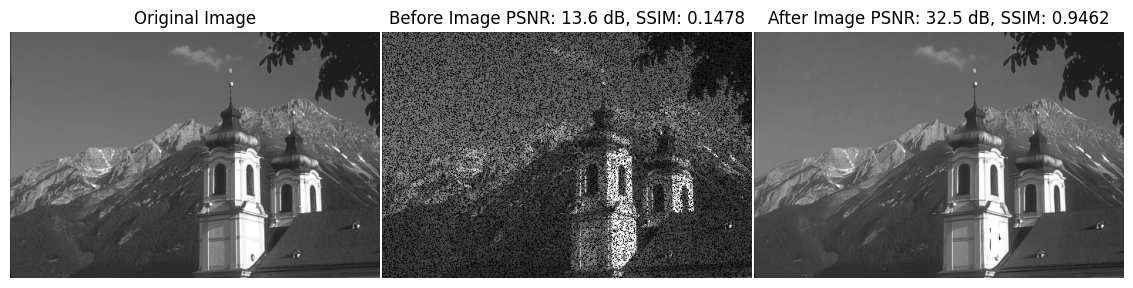

In [ ]:
# plot_before_after_and_original(arr, arr_bernoulli, predict_restormer(arr_bernoulli))
plot_before_after_and_original(arr, arr_bernoulli, model.predict(arr_bernoulli))

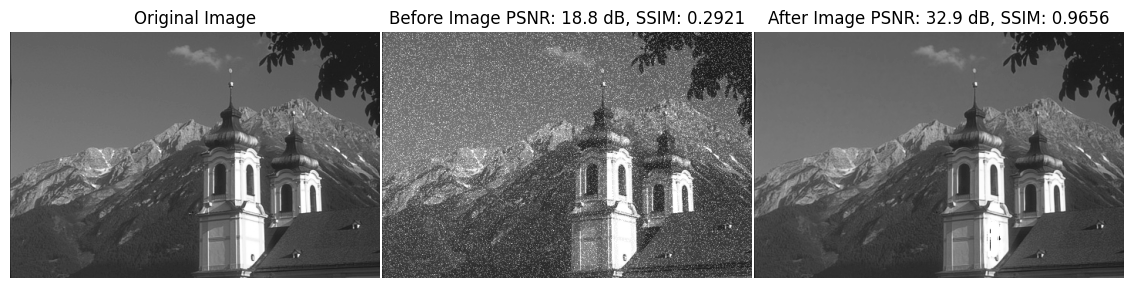

In [ ]:
# plot_before_after_and_original(arr, arr_poisson, predict_restormer(arr_poisson))
plot_before_after_and_original(arr, arr_poisson, model.predict(arr_poisson))

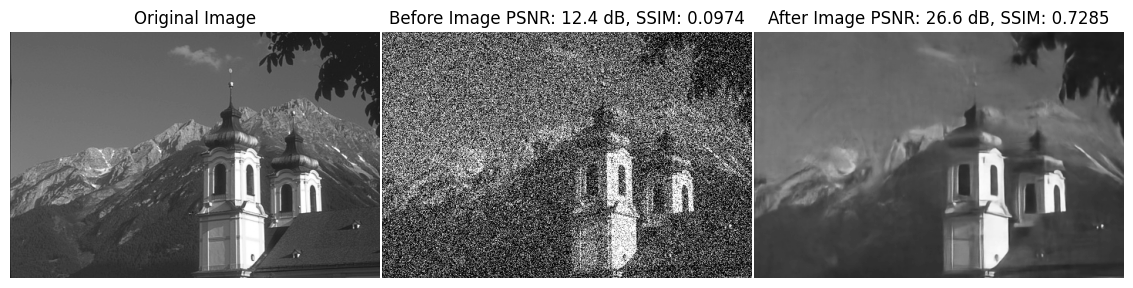

In [ ]:
plot_before_after_and_original(arr, arr_gaussian, model.predict(arr_gaussian))

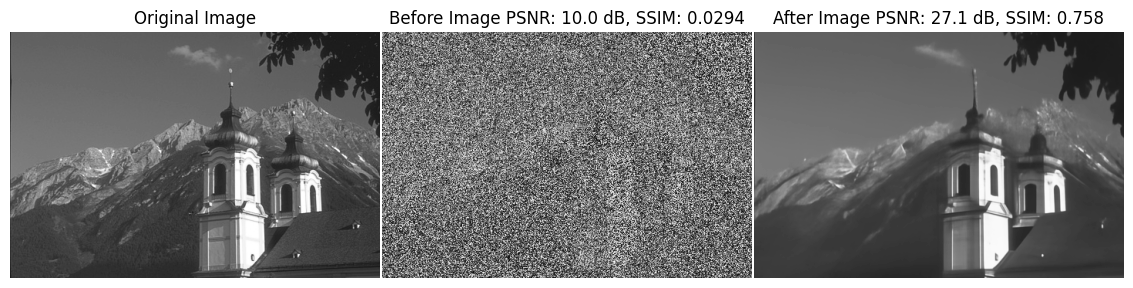

In [ ]:
x = np.expand_dims(arr + np.random.normal(0, 70, arr.shape), 0)/255
plot_before_after_and_original(arr, x * 255, predict_restormer(x) * 255)
# x = np.clip(np.expand_dims(arr + np.random.normal(0, 20, arr.shape), 0), 0, 255)
# plot_before_after_and_original(arr, x, model.predict(x))
# plot_before_after_and_original(arr, arr_gaussian, model.predict(arr_gaussian))